In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from environment import FurnaceEnvironment, TorchFurnaceEnvironment
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 0. Introduction

This heat simulator simulates the diffusion of heat in the 2-dimensional space. It assumes the situation that there are $M$ number of heaters and $N$ number of sensors in the square. You can choose the location of the sensors and heaters as you want but they should be on the grid point. At each (simulation) time-step $t$, heaters produce the heat $a_t \in \mathbb{R}^M$ for some small time $\Delta t$ and each sensor observes the heat $s_{t+1} \in \mathbb{R}^N$. The dynamic of this simulator can be summarized as this simple equation:

$s_{t+1}=f(s_t, a_t)$

It uses Finite Difference Method to approximate the Heat Equation with the square grid. There are two versions of simulators and one is bulit on NumPy to use conveniently and the other is bulit on PyTorch to make the simulator differentiable.

# 1. NumPy Version

## a. Initialization

In [2]:
num_grid = 10  # The number of grid in the space, int
diff_constant = 1.0 # diffusion constant in the Heat Equation, float
delta_t = 0.0025  # the size of time grid in FDM, float  
domain = [0.0, 1.0]  # the range of square side, List
timestep = 0.1  # the tick of each time-step, float
state_pos = np.array([[3, 3], [5, 6]]) # The location of sensors, [N x 2] int numpy array
action_pos = np.array([[2, 2], [3, 6]])  # The location of heaters, [M x 2] int numpy array

In [3]:
env = FurnaceEnvironment(num_grid, diff_constant, delta_t, domain, timestep, state_pos, action_pos)
env.reset()

## b. Step

In [4]:
a = np.array([1.0, 2.0])  # The amount of heat the heaters produce, [M] numpy array
s = env.step(a)  # The observed heat at the sensors, [N] numpy array
print(s)

[0.0028468  0.00295587]


In [5]:
state_traj = []
action_traj = []
state_traj.append(np.zeros(state_pos.shape[0]))

env = FurnaceEnvironment(num_grid, diff_constant, delta_t, domain, timestep, state_pos, action_pos)
env.reset()
for i in range(10):
    a = np.random.uniform(0, 1, size=(action_pos.shape[0]))
    s = env.step(a)
    action_traj.append(a)
    state_traj.append(s)
state_traj = np.stack(state_traj)
action_traj = np.stack(action_traj)

Text(0.5, 0.98, 'Simulator Example')

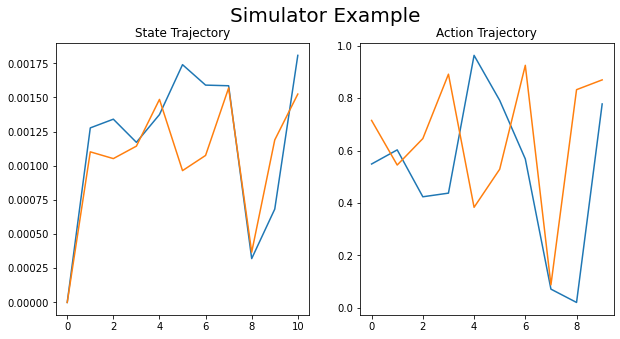

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes_flatten = axes.flatten()
axes_flatten[0].plot(state_traj)
axes_flatten[1].plot(action_traj)
axes_flatten[0].set_title('State Trajectory')
axes_flatten[1].set_title('Action Trajectory')
fig.suptitle('Simulator Example', fontsize=20)

# 2. PyTorch Version

## a. Initialization

In [7]:
num_grid = 10  # The number of grid in the space, int
diff_constant = 1.0 # diffusion constant in the Heat Equation, float
delta_t = 0.0025  # the size of time grid in FDM, float  
domain = [0.0, 1.0]  # the range of square side, List
timestep = 0.1  # the tick of each time-step, float
state_pos = torch.tensor([[3, 3], [5, 6]], device=device) # The location of sensors, [N x 2] int torch tensor
action_pos = torch.tensor([[2, 2], [3, 6]], device=device)  # The location of heaters, [M x 2] int numpy array

In [8]:
env = TorchFurnaceEnvironment(num_grid, diff_constant, delta_t, domain, timestep, state_pos, action_pos, device)
env.reset()

c:\users\song chi hyeon\anaconda3\envs\mpc37\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## b. Step

In [9]:
a = torch.tensor([1.0, 2.0], device=device)  # The amount of heat the heaters produce, [M] numpy array
s = env.step(a)  # The observed heat at the sensors, [N] numpy array
print(s)

tensor([0.0028, 0.0030], grad_fn=<IndexBackward0>)


In [10]:
state_traj = []
action_traj = []
state_traj.append(torch.zeros(state_pos.shape[0]).to(device))

env = TorchFurnaceEnvironment(num_grid, diff_constant, delta_t, domain, timestep, state_pos, action_pos, device)
env.reset()
for i in range(10):
    a = torch.from_numpy(np.random.uniform(0, 1, size=(action_pos.shape[0]))).to(device)
    s = env.step(a)
    action_traj.append(a)
    state_traj.append(s)
state_traj = torch.stack(state_traj)
action_traj = torch.stack(action_traj)

Text(0.5, 0.98, 'Simulator Example')

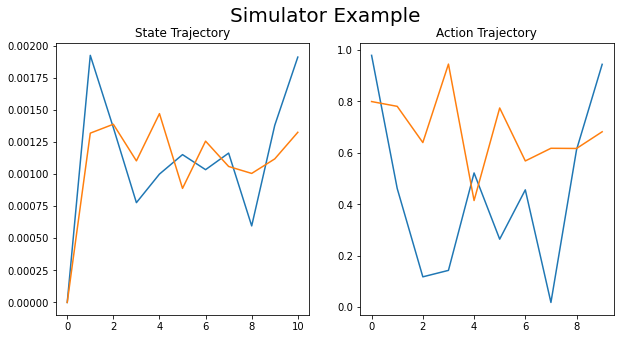

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes_flatten = axes.flatten()
axes_flatten[0].plot(state_traj.cpu().detach().numpy())
axes_flatten[1].plot(action_traj.cpu().detach().numpy())
axes_flatten[0].set_title('State Trajectory')
axes_flatten[1].set_title('Action Trajectory')
fig.suptitle('Simulator Example', fontsize=20)

## c. Differentiable

In [12]:
env = TorchFurnaceEnvironment(num_grid, diff_constant, delta_t, domain, timestep, state_pos, action_pos, device)
env.reset()

action = torch.tensor([[1.0, 1.0], [3.0, 3.0]], requires_grad=True, device=device)
state = []
for a in action:
    s = env.step(a)
    state.append(s)
state = torch.stack(state)
target = torch.tensor([[0.001, 0.001],[0.002, 0.002]], device=device)
crit = torch.nn.MSELoss()
loss = crit(state, target)
loss.backward()

In [13]:
loss

tensor(7.7324e-06, grad_fn=<MseLossBackward0>)

In [14]:
action.grad

tensor([[1.0655e-06, 1.3539e-06],
        [3.4017e-06, 3.7384e-06]])